In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
df = pd.read_csv('./sampled_dataset2.csv')

In [6]:
selected_features = ['Src Port', 'Dst Port', 'Flow Duration', 'Total Length of Fwd Packet', 
                     'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Flow IAT Min', 
                     'Fwd IAT Min', 'Fwd Header Length', 'Bwd Packets/s', 'Packet Length Max', 
                     'Packet Length Std', 'RST Flag Count', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 
                     'Idle Mean', 'Idle Max']

In [7]:
X_selected = df[selected_features]  # Keep only selected features
y = df['Label']  # Target variable

In [8]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.20, stratify=y, random_state=42)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1),
    "ANN": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, random_state=42)
}

In [12]:
predictions = {}
metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store predictions
    predictions[name] = y_pred

    # Compute evaluation metrics
    metrics[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    }

Training SVM...
Training Random Forest...
Training XGBoost...


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 7216, number of negative: 8000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 15216, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474238 -> initscore=-0.103141
[LightGBM] [Info] Start training from score -0.103141
Training ANN...


In [13]:
ensemble_model = VotingClassifier(estimators=[
    ("SVM", models["SVM"]),
    ("Random Forest", models["Random Forest"]),
    ("XGBoost", models["XGBoost"]),
    ("LightGBM", models["LightGBM"]),
    ("ANN", models["ANN"])
], voting='soft')

print("Training Ensemble Model...")
ensemble_model.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

Training Ensemble Model...


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7216, number of negative: 8000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 15216, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474238 -> initscore=-0.103141
[LightGBM] [Info] Start training from score -0.103141


In [14]:
predictions["Ensemble"] = y_pred_ensemble
metrics["Ensemble"] = {
    "Accuracy": accuracy_score(y_test, y_pred_ensemble),
    "Precision": precision_score(y_test, y_pred_ensemble, average='weighted'),
    "Recall": recall_score(y_test, y_pred_ensemble, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_ensemble, average='weighted')
}

In [15]:
# ✅ Step 5: Print Metrics
df_metrics = pd.DataFrame(metrics).T
print("\n🔹 Model Performance Comparison:")
print(df_metrics)


🔹 Model Performance Comparison:
               Accuracy  Precision    Recall  F1 Score
SVM            0.939553   0.941609  0.939553  0.939364
Random Forest  0.996583   0.996599  0.996583  0.996583
XGBoost        0.997635   0.997638  0.997635  0.997635
LightGBM       0.998423   0.998425  0.998423  0.998423
ANN            0.981340   0.981378  0.981340  0.981344
Ensemble       0.996846   0.996859  0.996846  0.996846


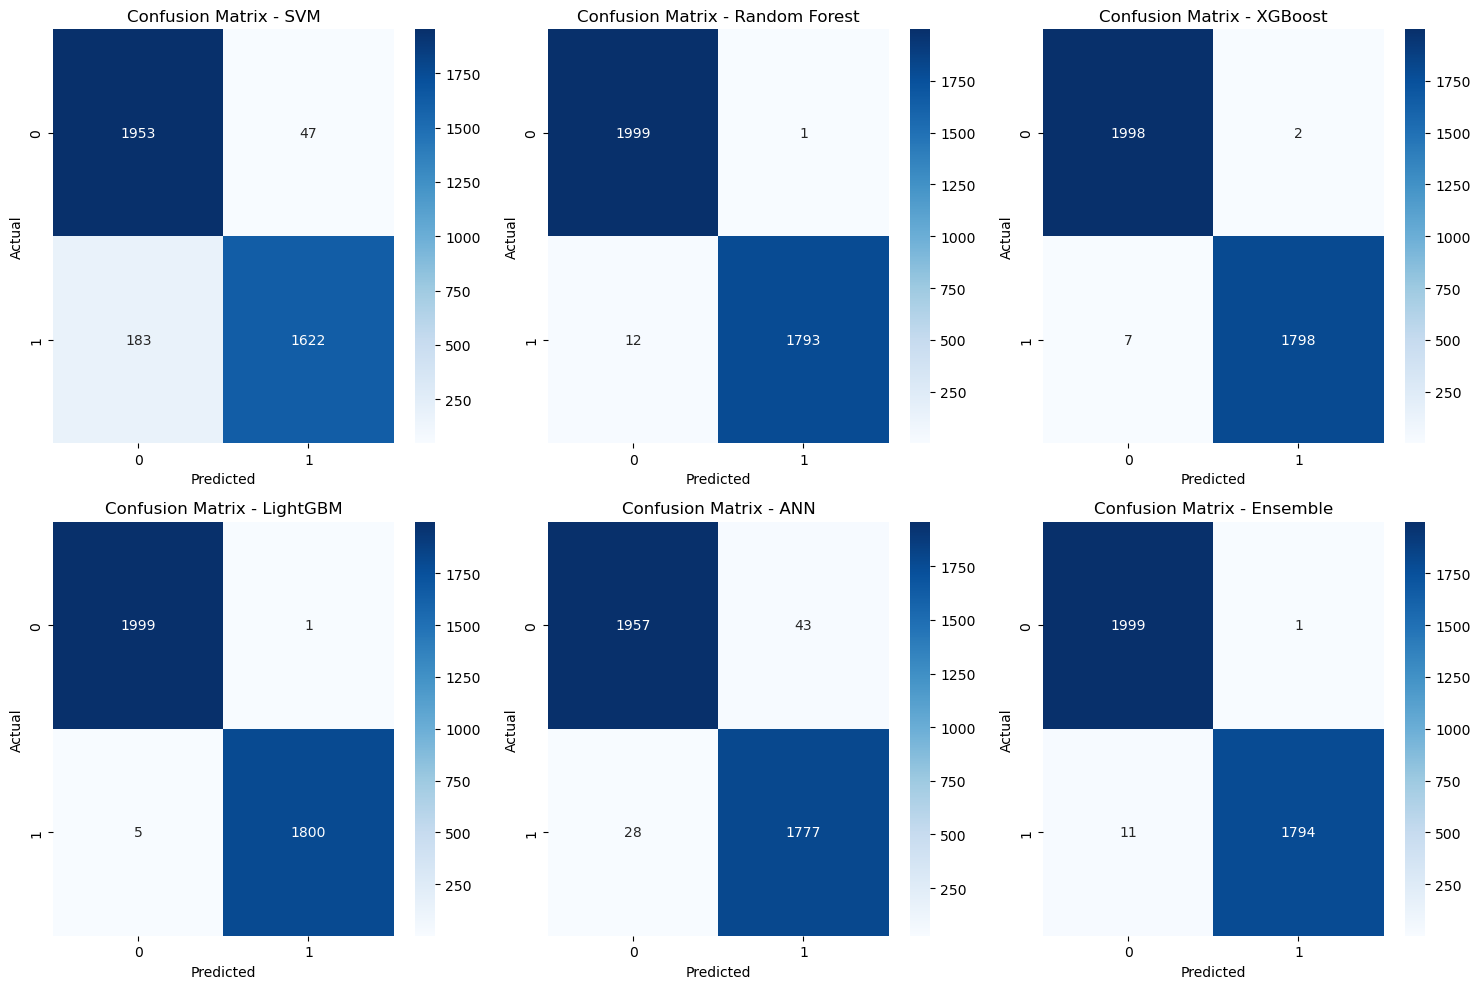

In [18]:
# ✅ Step 6: Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

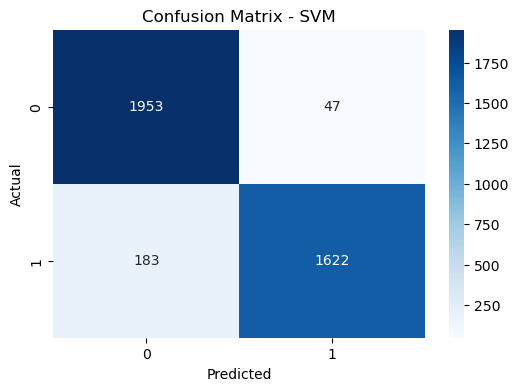

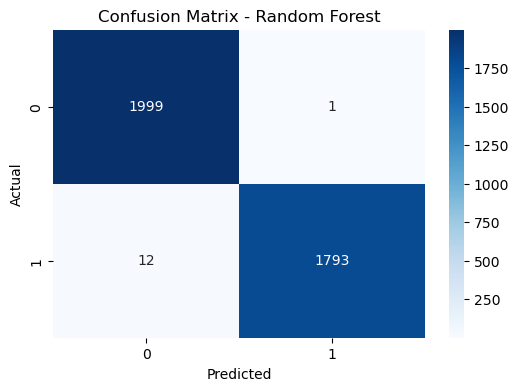

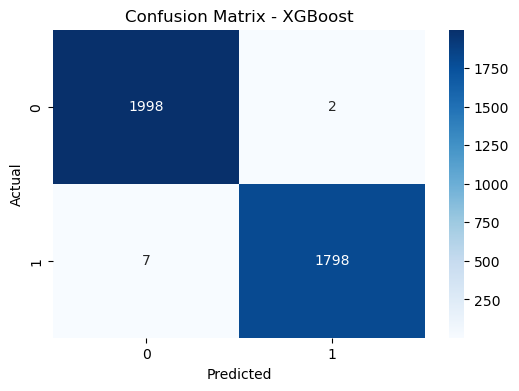

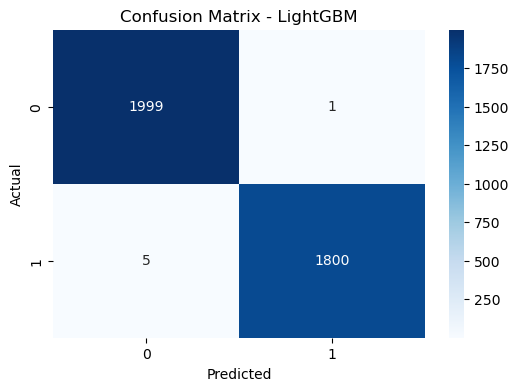

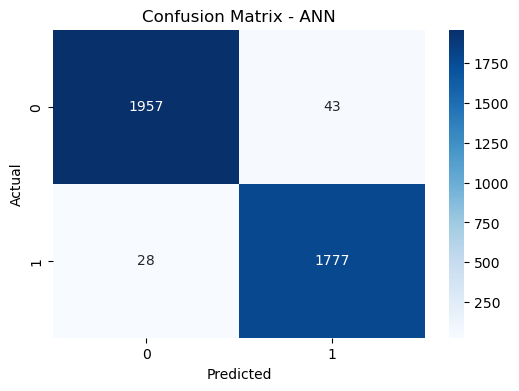

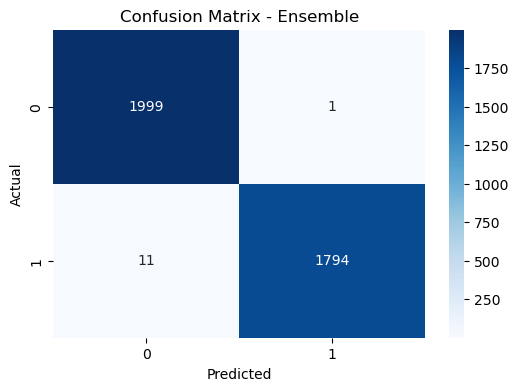

In [19]:
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.show()  # Show each plot separately


Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8770 - loss: 0.3476 - val_accuracy: 0.9348 - val_loss: 0.1646
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9432 - loss: 0.1440 - val_accuracy: 0.9566 - val_loss: 0.1350
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9599 - loss: 0.1252 - val_accuracy: 0.9566 - val_loss: 0.1211
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9614 - loss: 0.1151 - val_accuracy: 0.9635 - val_loss: 0.1116
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1086 - val_accuracy: 0.9635 - val_loss: 0.1099
Epoch 6/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9653 - loss: 0.1072 - val_accuracy: 0.9656 - val_loss: 0.1030
Epoch 7/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0954 - val_accuracy: 0.9693 - val_loss: 0.0977
Epoch 8/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.0907 - val_accuracy: 0.

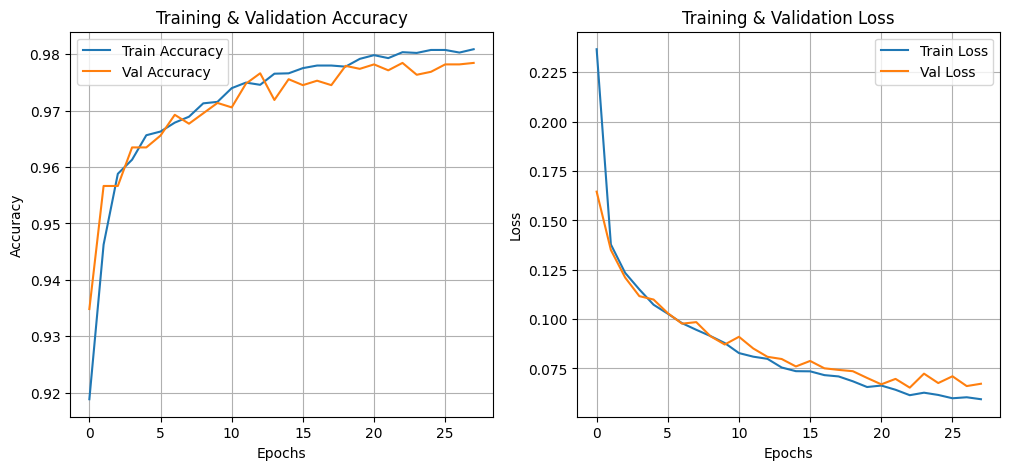

In [14]:
import tensorflow as tf
from tensorflow import keras

# ✅ Step 1: Define ANN Model
ann_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input Layer
    keras.layers.Dense(32, activation='relu'),  # Hidden Layer
    keras.layers.Dense(1, activation='sigmoid')  # Output Layer (Binary Classification)
])

# ✅ Step 2: Compile Model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Step 3: Define Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True,  # Restore the best weights before stopping
    verbose=1
)

# ✅ Step 4: Train ANN with Early Stopping & Validation Data
history = ann_model.fit(X_train_scaled, y_train, 
                        validation_data=(X_test_scaled, y_test), 
                        epochs=50, batch_size=32, 
                        verbose=1, callbacks=[early_stopping])

# ✅ Step 5: Evaluate Model
train_loss, train_acc = ann_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = ann_model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# ✅ Step 6: Plot Accuracy & Loss Graphs
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

# 🔹 Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

plt.show()

